## Classification d'extraits sonores

L'objectif de ce TP est de manipuler des données audio, sous plusieurs formes. Nous travaillerons sur une base de données extraite de [VoxLingua](http://bark.phon.ioc.ee/voxlingua107/). Le problème que nous chercherons à résoudre est celui de la **reconnaissance du langage parlé**. Pour simplifier le problème (et le rendre traitable dans le temps du TP), nous nous limiterons à seulement 7 langues, toutes d'origine latine : le français, l'espagnol, le catalan, l'occitan, le portugais, l'italien, et le roumain.

La base de données sur laquelle nous travaillerons contient 200 extraits audio par langue dans la base d'apprentissage, et 30 par langue dans la base de test. Elle vous permettra de prototyper rapidemet vos réseaux, mais induira très certainement **un fort surapprentissage**. 

Le traitement du signal audio par apprentissage profond est un vaste domaine, pour lequel il existe de multiples façons de traiter les problèmes. Nous en verrons aujourd'hui 3, qui seront complétées dans quelques semaines par les *transformers*. 

Commençons par télécharger les données :


In [47]:
!git clone https://github.com/axelcarlier/spokenlanguage.git

fatal: destination path 'spokenlanguage' already exists and is not an empty directory.


Les données sont chargées dans des variables *x_train*, *x_test*, *y_train* et *y_test*. 

In [48]:
import os
from scipy.io import wavfile
import numpy as np

languages = ['ca', 'es', 'fr', 'it', 'oc', 'pt', 'ro']
nb_images_train = 1400
nb_images_test = 210
sr = 16000

x_train = np.zeros((nb_images_train, 5*sr), dtype='float')
y_train = np.zeros((nb_images_train, len(languages)), dtype='float')
x_test = np.zeros((nb_images_test, 5*sr), dtype='float')
y_test = np.zeros((nb_images_test, len(languages)), dtype='float')

index_train = 0
index_test = 0
for lang in languages:

  lang_index = languages.index(lang)
  

  for file in os.listdir('spokenlanguage/Train/' + lang + '/'):
    samplerate, data = wavfile.read('spokenlanguage/Train/' + lang + '/' + file)

    x_train[index_train, :min(len(data), 5*16000)] = data[:min(len(data), 5*16000)]
    y_train[index_train, lang_index] = 1
    index_train = index_train + 1

  for file in os.listdir('spokenlanguage/Test/' + lang + '/'):
    samplerate, data = wavfile.read('spokenlanguage/Test/' + lang + '/' + file)

    x_test[index_test, :min(len(data), 5*16000)] = data[:min(len(data), 5*16000)]
    y_test[index_test, lang_index] = 1
    index_test = index_test + 1

    

Prenez le temps de regarder leur format. Les extraits sont coupés après 5 secondes, et sont complétés avec des '0' (*zero-padding*) lorsqu'ils sont trop courts. Chaque extrait a une fréquence d'échantillonnage de 16000/sec, et chaque donnée est donc réduite (ou étendue) à 80000 échantillons.

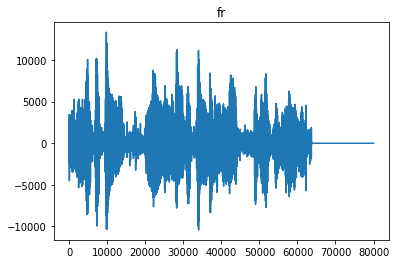

In [49]:
import matplotlib.pyplot as plt
import random
ind_sample = random.randint(0, x_train.shape[0])

# Affichage du signal 1D d'un des extraits
plt.plot(x_train[ind_sample])
plt.title(languages[np.argmax(y_train[ind_sample])])
plt.show()

## Travail à faire



1.   Construisez un premier réseau de neurones, simple, qui permet de classifier les signaux 1D selon les 7 classes (langues). Vous pouvez vous contenter d'une architecture simple (conv1D/pooling) pour obtenir ces premiers  résultats. 

  N.B. 1 : **Attention à la normalisation des données !**

  N.B. 2 : **Ne cherchez pas à corriger le surapprentissage !**

2.   Transformez le signal 1D en un log-spectrogramme de Mel, comme présenté ci-dessous dans l'exemple fourni. Vous vous retrouvez devant un problème de classification d'image, que vous pouvez maintenant tenter de résoudre avec des convolutions 2D, et un simple réseau de type VGG. 

  N.B. : **Attention à la normalisation des données !**

3.   En dernier recours, testez maintenant une architecture récurrente, comme par exemple un [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/). Vous pouvez considérer un signal audio comme une séquence de vecteurs d'intensités (correspondant à chaque fréquence du spectrogramme de Mel), et lier cette entrée à une (ou plusieurs) couches récurrentes, avant de terminer le réseau par une ou plusieurs couches denses.

  N.B. 1 : **Attention au format des données en entrée d'un LSTM : [batch, timesteps, feature]**

  N.B. 2 : **Attention, le problème est de type *many-to-one*, mais lorsque vous chaînez 2 couches récurrentes, la première doit également retourner une séquence !**

4.   Lorsque toutes vos architectures fonctionneront, vous pourrez les tester sur une base de données plus large. Voici le lien pour les récupérer :
```!git clone https://github.com/axelcarlier/spokenlanguage_large.git```

Attention, les fichiers ne sont plus au format .wav mais au format MP3 (pour gagner de l'espace et tenir sur Github), il vous faudra donc modifier le code de chargement des données. Il y a maintenant 2000 échantillons par classe dans la base de données.

In [60]:
x_train_normalized = (x_train - np.mean(x_train))/np.std(x_train)
x_test_normalized = (x_test - np.mean(x_train))/np.std(x_train)


In [62]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Input
from tensorflow.keras.models import Sequential

def create_model(input_size):
  model = Sequential([
    Input((input_size,1,)),

    Conv1D(32, 3, activation='relu'),
    MaxPool1D(),

    Conv1D(32, 3, activation='relu'),
    MaxPool1D(),
    
    Conv1D(32, 3, activation='relu'),
    MaxPool1D(),
    
    Conv1D(32, 3, activation='relu'),
    MaxPool1D(),

    Conv1D(32, 3, activation='relu'),
    MaxPool1D(),

    Flatten(),
        
    Dense(7, activation='softmax'),
  ])

  return model

In [65]:
model = create_model(5*sr)
model.summary()
model.compile(optimizer='Adam', loss='categorical_crossentropy')

model.fit(
    x_train_normalized, y_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_normalized, y_test)
)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_49 (Conv1D)          (None, 79998, 32)         128       
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 39999, 32)        0         
 g1D)                                                            
                                                                 
 conv1d_50 (Conv1D)          (None, 39997, 32)         3104      
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 19998, 32)        0         
 g1D)                                                            
                                                                 
 conv1d_51 (Conv1D)          (None, 19996, 32)         3104      
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 9998, 32)       

KeyboardInterrupt: 

## Spectrogramme de Mel

Le spectrogramme de Mel est une représentation temps/fréquence, comme le sonagramme que vous avez vu l'an passé, pour laquelle l'échelle des fréquences est adaptée à la perception humaine. C'est une représentation classique en traitement de la parole.

/tmp/ipykernel_91783/2389383061.py:5: FutureWarning: Pass y=[ 1868.  1682.  1808. ...  -683. -1842. -2194.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(x_train[0])


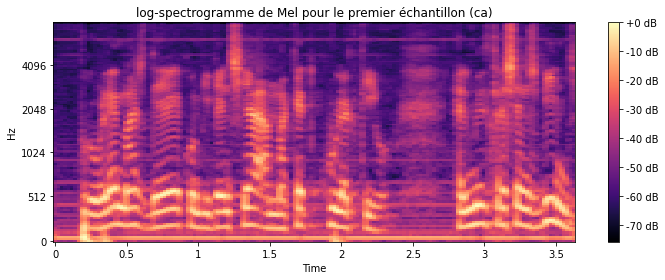

In [52]:
import matplotlib.pyplot as plt
import librosa.display

# Calcul du spectrogramme de Mel
S = librosa.feature.melspectrogram(x_train[0])

plt.figure(figsize=(10, 4))
# Passage en échelle logarithmique des énergies, pour mieux discerner le signal. 
S_dB = librosa.power_to_db(S, ref=np.max)

# Affichage du résultat
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('log-spectrogramme de Mel pour le premier échantillon (' + languages[np.argmax(y_train[0])] + ')' )
plt.tight_layout()
plt.show()

In [76]:
x_train_mel = np.zeros((x_train.shape[0], *S_dB.shape))
for i in range(x_train.shape[0]):
  x_train_mel[i] = librosa.feature.melspectrogram(x_train[i], sr=sr)

x_test_mel = np.zeros((x_test.shape[0], *S_dB.shape))
for i in range(x_test.shape[0]):
  x_test_mel[i] = librosa.feature.melspectrogram(x_test[i], sr=sr)

x_train_mel_normalized = (x_train_mel - np.mean(x_train_mel.flatten()))/np.std(x_train_mel.flatten())
x_test_mel_normalized = (x_test_mel - np.mean(x_train_mel.flatten()))/np.std(x_train_mel.flatten())

/tmp/ipykernel_91783/1318606634.py:3: FutureWarning: Pass y=[ 1868.  1682.  1808. ...  -683. -1842. -2194.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x_train_mel[i] = librosa.feature.melspectrogram(x_train[i], sr=sr)
/tmp/ipykernel_91783/1318606634.py:3: FutureWarning: Pass y=[2292. 2214. 2194. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x_train_mel[i] = librosa.feature.melspectrogram(x_train[i], sr=sr)
/tmp/ipykernel_91783/1318606634.py:3: FutureWarning: Pass y=[-26.  14.  20. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x_train_mel[i] = librosa.feature.melspectrogram(x_train[i], sr=sr)
/tmp/ipykernel_91783/1318606634.py:3: FutureWarning: Pass y=[ 34.  36.  50. ... -50. -99. -37.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x

In [92]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential

def create_model(input_shape):
  model = Sequential([
    Input((input_shape[0], input_shape[1],1)),

    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
        
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(256, 3, activation='relu'),
    MaxPool2D(),

    Flatten(),

    Dense(256, activation='relu'),

    Dense(7, activation='softmax'),
  ])

  return model

In [93]:
model = create_model(S_dB.shape)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(
    x_train_mel_normalized, y_train,
    epochs=20,
    batch_size=16,
    shuffle=True,
    validation_data=(x_test_mel_normalized, y_test)
)


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 126, 155, 32)      320       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 63, 77, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 61, 75, 64)        18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 30, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 28, 35, 128)       73856     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 14, 17, 128)    

ValueError: Data cardinality is ambiguous:
  x sizes: 128
  y sizes: 1400
Make sure all arrays contain the same number of samples.

# 3. LSTM

In [115]:
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input
from tensorflow.keras.models import Sequential

def create_model(input_shape):
  model = Sequential([
    Input((input_shape[1], input_shape[0])),

    LSTM(128, activation="relu", return_sequences=True),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),

    Dense(256, activation='relu'),

    Dense(7, activation='softmax'),
  ])

  return model

In [116]:
model = create_model(S_dB.shape)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 157, 128)          131584    
                                                                 
 lstm_28 (LSTM)              (None, 157, 64)           49408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_62 (Dense)            (None, 256)               8448      
                                                                 
 dense_63 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 203,655
Trainable params: 203,655
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.fit(
    x_train_mel_normalized.swapaxes(1, 2), y_train,
    epochs=20,
    batch_size=16,
    shuffle=True,
    validation_data=(x_test_mel_normalized.swapaxes(1, 2), y_test)
)

Epoch 1/20
88/88 [==============================] - 18s 175ms/step - loss: nan - accuracy: 0.1386 - val_loss: nan - val_accuracy: 0.1429
Epoch 2/20
88/88 [==============================] - 16s 177ms/step - loss: nan - accuracy: 0.1429 - val_loss: nan - val_accuracy: 0.1429
Epoch 3/20
88/88 [==============================] - 15s 172ms/step - loss: nan - accuracy: 0.1429 - val_loss: nan - val_accuracy: 0.1429
Epoch 4/20
43/88 [=============>................] - ETA: 7s - loss: nan - accuracy: 0.1308

KeyboardInterrupt: 